# Neural networks

[Neural Networks tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

[torch.nn](https://pytorch.org/docs/stable/nn.html)

[Series](https://www.youtube.com/watch?v=i2yPxY2rOzs)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        # this is the place where you instantiate all your modules
        # you can later access them using the same names you've given them in
        # here
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, ...)
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # it's the forward function that defines the network structure
        # we're accepting only a single input in here, but if you want,
        # feel free to use more
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net() # referring to the name inside super()

print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
params = list(net.parameters()) # The learnable parameters of a model
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [ ]:
#Let’s try a random 32x32 input
# nSamples x nChannels x Height x Width

input = torch.randn(1, 1, 32, 32)
# test = torch.randn(32, 32)
out = net(input)
# print(test)
print(input)
print(out)

tensor([[[[ 1.2923,  0.4736, -1.2683,  ..., -0.7800,  1.1590, -1.8154],
          [ 0.3857, -1.2475, -0.8089,  ..., -0.4327, -1.1460,  1.3511],
          [-0.7658,  0.5496,  0.3310,  ..., -1.1194, -0.6671, -0.2369],
          ...,
          [ 1.4039, -0.1211,  1.0557,  ..., -1.0178,  0.3359, -1.3673],
          [-0.5415, -0.9066,  0.4037,  ...,  0.2217, -1.6301, -0.2150],
          [ 0.5196, -0.0895, -0.1229,  ..., -0.7816, -0.8644, -1.3759]]]])
tensor([[-0.1133,  0.0737,  0.0688,  0.1385,  0.0659, -0.0600, -0.1041, -0.0462,
         -0.0847, -0.0026]], grad_fn=<AddmmBackward>)


# New Section

In [ ]:
# Zero the gradient buffers of all parameters and backprops with random gradients:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [ ]:
# Loss function
# A loss function takes the (output, target) pair of inputs, 
# and computes a value that estimates how far away the output is from the target.

output = net(input)
target = torch.randn(10)  # a dummy target, for example
print(target)
target = target.view(1, -1)  # make it the same shape as output
print(target)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

# Now, if you follow loss in the backward direction, 
# using its .grad_fn attribute, you will see a graph of computations that looks like this:
# input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
#     -> view -> linear -> relu -> linear -> relu -> linear
#     -> MSELoss
#     -> loss

tensor([-0.0323,  0.2260,  0.6005,  0.1256, -0.1308,  1.4796, -0.6631,  0.2755,
         0.1990, -0.3935])
tensor([[-0.0323,  0.2260,  0.6005,  0.1256, -0.1308,  1.4796, -0.6631,  0.2755,
          0.1990, -0.3935]])
tensor(0.3289, grad_fn=<MseLossBackward>)


In [ ]:
# So, when we call loss.backward(), the whole graph is differentiated w.r.t. the loss,
#  and all Tensors in the graph that has requires_grad=True will have their .grad Tensor accumulated with the gradient.

print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [ ]:
# Backprop

# To backpropagate the error all we have to do is to loss.backward(). 
# You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0086,  0.0019, -0.0008, -0.0054, -0.0074, -0.0013])


In [ ]:
# Update the weights
# The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):
# weight = weight - learning_rate * gradient

learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

print(net.conv1.bias.grad)

tensor([ 0.0090, -0.0009, -0.0063, -0.0026, -0.0080, -0.0079])


In [ ]:
# optim package allows you to chooose different optimizers (SGD, Nesterov-SGD, Adam, RMSProp, etc.)
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers because gradients are accumulated
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

print(net.conv1.bias.grad)

tensor([-9.3416e-06, -7.3086e-03, -1.3786e-02, -2.0886e-03, -3.9035e-03,
        -1.7396e-02])


# Image Classifier

[Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [ ]:
# 1. Loading and normalizing CIFAR10
# The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1].

# Turn the data into a tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


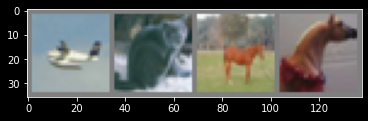

    plane       cat     horse     horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader) # allow print next item in list by using .next()
images, labels = dataiter.next()

# print(torchvision.utils.make_grid(images))
# print(torchvision.utils.make_grid(images) / 2 + 0.5)
# print((torchvision.utils.make_grid(images) / 2 + 0.5).numpy())

# show images
imshow(torchvision.utils.make_grid(images))
# print(classes)
# print(labels)
print(' '.join('%9s' % classes[labels[j]] for j in range(4))) #%9s = 9 placeholder for string

In [ ]:
# Define a Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input, 6 out, 5*5 conv
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
# Define a Loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train the network
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # 0 is the default start anyway
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net(inputs) # forward
        loss = criterion(outputs, labels) # loss
        loss.backward() # backward
        optimizer.step() # optimize

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % # %s is placeholder for string
                                           # %d is placeholder for number
                                           # %.3f = 3 decimal values
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.145
[1,  4000] loss: 1.829
[1,  6000] loss: 1.685
[1,  8000] loss: 1.560
[1, 10000] loss: 1.505
[1, 12000] loss: 1.459
[2,  2000] loss: 1.368
[2,  4000] loss: 1.362
[2,  6000] loss: 1.321
[2,  8000] loss: 1.284
[2, 10000] loss: 1.268
[2, 12000] loss: 1.258
Finished Training


In [ ]:
# save our model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

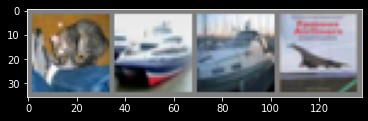

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# let’s load back in our saved model 
# (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
# The outputs are energies for the 10 classes. The higher the energy for a class, 
# the more the network thinks that the image is of the particular class. 
# So, let’s get the index of the highest energy:

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [ ]:
# What are the classes that performed well, and the classes that did not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 72 %
Accuracy of  bird : 46 %
Accuracy of   cat : 24 %
Accuracy of  deer : 54 %
Accuracy of   dog : 38 %
Accuracy of  frog : 79 %
Accuracy of horse : 53 %
Accuracy of  ship : 52 %
Accuracy of truck : 65 %


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)